# <center> <b> <font color='blue'> Forecasting and Evaluation in Time Series </center> </b> </font>

## <font color='#1f618d'> Table of Contents </font>

1. [Introduction](#1)
2. [Setup](#2)
3. [Helper Functions](#3)
4. [Generating Syntehtic Data](#4)
5. [Recursive Forecasting](#5)
6. [Multi-output Forecasting](#6)
7. [Direct Forecasting](#7)
8. [Comparison](#8)
9. [Typical use cases for each type of forecasting](#9) <br>
    9.1.[Recursive Forecasting](#9.1) <br>
    9.2.[Direct Forecasting](#9.2)
10. [Annex](#annex) <br>
    A. [A little more about predictions](#A) <br>
    B. [A Note on Direct Multi-Step Forecasting ](#B) <br>
11. [References](#references)

<a name="1"></a>
## <font color='#1f618d'> <b> 1. Introduction </font> </b>

Forecasting means predicting future values based on past observations of a time series. In machine learning, this involves training models to learn patterns in historical data and use them to make informed predictions.

A key concept in forecasting is the **forecasting horizon** — the number of time steps into the future we aim to predict. 

There are several strategies to handle this, each with its own trade-offs:

- **Recursive Forecasting**  
  A single model is trained to predict the next time step. This prediction is then fed back into the model to predict subsequent steps, one at a time. While simple, this method can accumulate error over long horizons.

- **Direct Forecasting**  
  A separate model is trained for each future time step. For example, one model predicts t+1, another t+2, and so on. This avoids error accumulation but requires more models.

- **Multi-Output Forecasting** (sometimes grouped with direct methods)  
  A single model is trained to predict *all* future steps in the horizon at once (e.g., predicting the next 7 days in one shot). This approach captures dependencies across future steps but may require more complex modeling.

In this notebook, we'll explore these forecasting strategies using machine learning techniques, demonstrating their implementation, strengths, and limitations.

<a name="2"></a>
## <font color='#1f618d'> <b> 2. Setup </font> </b>

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error
from dataclasses import dataclass
from absl import logging
logging.set_verbosity(logging.ERROR)

In [3]:
# Seed for reproducibility
np.random.seed(42)

In [5]:
# Save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    WINDOW_SIZE = 3
    HORIZON = 1
    BATCH_SIZE = 32

<a name="3"></a>
## <font color='#1f618d'> <b> 3. Helper Functions </font> </b>

### Pre-processing

In [9]:
def train_val_split(time, series, time_step=800):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


In [14]:
def windowed_dataset(series, 
                     window_size=G.WINDOW_SIZE, 
                     horizon=G.HORIZON, 
                     batch_size=G.BATCH_SIZE, 
                     shuffle_buffer=10,
                     shuffle=True):
    
    # Create the dataset from the series
    ds = tf.data.Dataset.from_tensor_slices(series)
    
    # Create windows of size (window_size + horizon)
    ds = ds.window(window_size + horizon, shift=1, drop_remainder=True)
    
    # Flatten the windows into batches
    ds = ds.flat_map(lambda w: w.batch(window_size + horizon))
    
    if shuffle:
        ds = ds.shuffle(shuffle_buffer)
    
    # Split the windows into features and labels
    ds = ds.map(lambda w: (w[:-horizon], w[-horizon:]))
    
    # Batch the dataset
    ds = ds.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return ds

<a name="4"></a>
## <font color='#1f618d'> <b> 4. Generating Synthetic Data </font> </b>

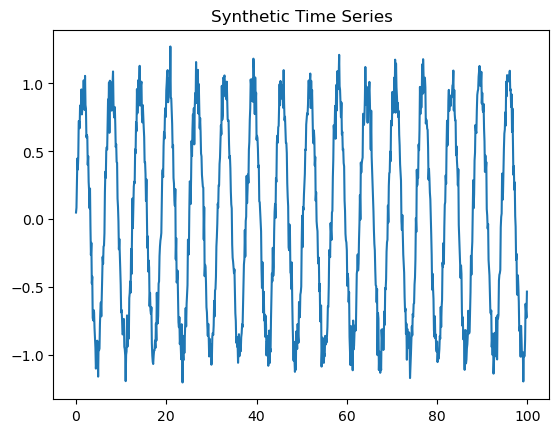

In [7]:
# Generate synthetic time series (sine + noise)
time = np.arange(0, 100, 0.1)
series = np.sin(time) + 0.1 * np.random.randn(len(time))

plt.plot(time, series)
plt.title("Synthetic Time Series")
plt.show()

<a name="5"></a>
## <font color='#1f618d'> <b> 5. Recursive Forecasting </font> </b>

### Prepare data

In [11]:
# Train/Test Split
time_train, series_train, time_valid, series_valid = train_val_split(time, series)
time_train.shape, time_valid.shape

((800,), (200,))

In [15]:
# Apply the transformation to the training set and val set (horizon=1)
dataset_train = windowed_dataset(series_train, shuffle=True)
dataset_val = windowed_dataset(series_valid, shuffle=False)

In [16]:
for x,y in dataset_train:
    print(x.shape,y.shape)
    break

(32, 3) (32, 1)


### Model

In [18]:
def create_model(horizon):
    
    model = tf.keras.models.Sequential([ 
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1),input_shape=[None]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(horizon),
        #tf.keras.layers.Lambda(lambda x: x*100.0)
    ]) 
    
    model.compile(loss='mse',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  metrics=["mae"])  

    return model

model = create_model(1) # predicts 1 step ahead!!!

In [19]:
# train the model
history = model.fit(dataset_train,
                    epochs=50, 
                    verbose=0,
                    validation_data=dataset_val)

### Forecast

In recursive forecasting, we train a model to **predict one time step ahead**. Then, we use that prediction to update the input window and generate the next prediction. This process is repeated until we reach the desired number of predictions.

The key idea is:

- Start with an initial input window.  
  - During testing, this corresponds to:
    - The first *window size* values of the test set (i.e., the unwindowed series), or (equivalently)
    - The first window from the windowed test set.
- Use this window to generate the first prediction.
- Shift the window: remove the oldest value and append the prediction to form the next input window.
- Use this new window to predict the next time step.
- Repeat this process until the desired number of predictions is obtained.  
  - During testing, this number typically equals:
    - `len(test set without windowing) - window size`, or  
    - `len(windowed test set)`.
 
<img src="images/h1.png"/>

In [20]:
def forecast(model, initial_window, num_predictions, verbose=False):
    """
    Generate recursive forecasts using a model that predicts one step ahead.
    
    This function assumes the model is pre-trained and fixed during forecasting.
    In scenarios with concept drift or non-stationary data, it may be beneficial to retrain or fine-tune the model as new true values become available,
    but that is not implemented here.


    Parameters
    ----------
    model : keras.Model or similar
        A trained model with a `predict` method that takes input of shape (1, window_size).
    
    initial_window : np.ndarray
        The initial input window (1D array) to start forecasting from.
    
    num_predictions : int
        The number of future time steps to predict.
    
    verbose : bool, optional
        If True, prints the current input window and the corresponding prediction at each step.

    Returns
    -------
    np.ndarray
        Array of predicted values with length equal to `num_predictions`.

    Notes
    -----
    This function uses recursive forecasting: each prediction is fed back into the input window
    to predict the next time step. Over long horizons, this may lead to error accumulation.
    """

    # Input validation
    if not isinstance(initial_window, np.ndarray):
        raise TypeError("initial_window must be a NumPy array.")
    if initial_window.ndim != 1:
        raise ValueError("initial_window must be a 1D array.")
    
    predictions = []
    current_window = initial_window.copy()  # Start with the initial window

    for _ in range(num_predictions):
        
        # Make a prediction based on the current window
        pred = model.predict(current_window[np.newaxis], verbose=0)
        predictions.append(pred[0][0])
        
        if verbose:
            print(f"Current window: {current_window}")
            print(f"Prediction: {pred[0][0]:.2f}")
            print("\n")

        # Update the window: remove the oldest value and add the new prediction
        current_window = np.roll(current_window, -1)  # Shift the window left
        current_window[-1] = pred[0][0]  # Add the new prediction at the end

    return np.array(predictions)

Let's forecast the next 4 time steps using a random initial window.

In [22]:
num_predictions = 4
initial_window = np.array([53.53772,   54.78016,   62.50613])

forecast(model, initial_window, num_predictions, True)

Current window: [53.53772 54.78016 62.50613]
Prediction: 2.42


Current window: [54.78016    62.50613     2.42163348]
Prediction: 2.70


Current window: [62.50613     2.42163348  2.70044112]
Prediction: 2.52


Current window: [2.42163348 2.70044112 2.51989865]
Prediction: 1.85




array([2.4216335, 2.7004411, 2.5198987, 1.8482867], dtype=float32)

Now, let's generate forecasts for the entire length of the validation set.

### Initial Window

In [25]:
# begin of val set (not windowed)
print(series_valid[:G.WINDOW_SIZE])

# take first window
for x, y in dataset_val.take(1):
    initial_test_window = x.numpy()[0] #x.numpy() is the first batch
    
print(initial_test_window)

series_valid[:3] == initial_test_window

[-0.90006027 -1.05154816 -0.98639553]
[-0.90006027 -1.05154816 -0.98639553]


array([ True,  True,  True])

### Number of Predictions

In [26]:
### Number of preds
print(len(series_valid) - G.WINDOW_SIZE - G.HORIZON + 1)

# number of samples in the val set
num_samples = dataset_val.reduce(0, lambda x, batch: x + tf.shape(batch[0])[0]).numpy()
print("Total number of samples:", num_samples)

197
Total number of samples: 197


### Predictions

In [27]:
preds = forecast(model, series_valid[:G.WINDOW_SIZE], num_samples)

In [28]:
preds.shape

(197,)

In [29]:
preds[0],preds[1]

(-0.9942321, -0.96050644)

### Evaluation

In [30]:
# Calculate MAE directly using the metric function
mae = tf.keras.metrics.mean_absolute_error(series_valid[G.WINDOW_SIZE:], preds) # series_valid is NOT windowed
        # that's why we start to compare from the index equal to the window size
mae

<tf.Tensor: shape=(), dtype=float32, numpy=0.86557734>

<a name="6"></a>
## <font color='#1f618d'> <b> 6. Multi-Output Forecasting </font> </b>

We will train one model to forecast multiple time steps at once; in our example, it will predict the next 7 steps.

### Preparing data

In [31]:
horizon = 7

dataset_train_2 = windowed_dataset(series_train, horizon=horizon, shuffle=False)
dataset_val_2 = windowed_dataset(series_valid, horizon=horizon, shuffle=False)

In [32]:
for x,y in dataset_train_2:
    print(x.shape, y.shape)
    break

(32, 3) (32, 7)


### Model

In [33]:
model2 = create_model(horizon) # horiozn=7, so it wll forecast 7 time steps ahead at once

In [34]:
history2 = model2.fit(dataset_train_2, 
                    epochs=50, 
                    verbose=0,
                    validation_data=dataset_val_2)

### Forecast

In [36]:
data = np.array([53.53772,   54.78016,   62.50613])
preds = model2.predict(data[np.newaxis])
preds.shape, preds

1/1 [==============================] - 0s 20ms/step


((1, 7),
 array([[0.9802833 , 1.1418878 , 1.1473898 , 0.77944696, 0.71591616,
         0.35237014, 0.18035999]], dtype=float32))

In [39]:
# see the preds for the 2 first time steps
preds[0][0], preds[0][1]

(0.9802833, 1.1418878)

### Evaluation

To evaluate such a model (in order to compare with others) we can assume that the "validation data" is the real data.

✅ Sliding window in validation (using t1, t2, t3 after using t0, t1, t2).

If you use windowed_dataset(...) to slide the window by 1 step, you'll have:

input: [t0, t1, t2] → predict [t3, ..., t9]

input: [t1, t2, t3] → predict [t4, ..., t10] ← here you're using t3, which was in the target of the previous window.

👉 This is not an issue during validation.

In production, you can’t use the second input window unless you already know t3.

So...

✅ In **production** you must use real future data for each new prediction window Exatly. In direct forecasting, you need true recent values for each prediction window.

So in production:

- You'd wait for new data to come in before making the next horizon-step (7 on our example) prediction.

Or retrain/update as new observations arrive.

You don't recursively use your predictions as inputs (that would be recursive forecasting, a different setup).

✅ In **validation** you trust the future values as ground truth Exactly:

- You assume series_valid is the truth.

- You simulate how the model would behave if it were fed real data at every step.

That makes model comparison fair — as long as all models are evaluated in the same way.

🔁 Summary


| Context        | Input values come from      | Can you use sliding windows?           | Are repeated predictions OK?       |
|----------------|-----------------------------|----------------------------------------|-------------------------------------|
| **Validation** | "Real data" (`series_valid`)| ✅ Yes — simulation with true inputs   | ✅ Yes — allows model comparison    |
| **Production** | Latest observed real data   | ❌ No — only when new data arrives     | ❌ No — must wait for real data     |




We can either evaluate the model using TensorFlow's built-in model.evaluate method or implement a custom evaluation. Let's try both approaches.

In [40]:
# TF's built-in model.evaluate
loss, mae = model2.evaluate(dataset_val_2)

6/6 [==============================] - 0s 7ms/step - loss: 0.0641 - mae: 0.1937


In [41]:
# Custom Method

# Extract true targets from dataset_val_2
y_true = []
y_pred = []

for x, y in dataset_val_2:
    preds = model2.predict(x, verbose=0)
    y_pred.append(preds)
    y_true.append(y.numpy())

# Concatenate all predictions and true values
y_true = np.concatenate(y_true, axis=0)
y_pred = np.concatenate(y_pred, axis=0)

In [42]:
y_true.shape, y_pred.shape


((191, 7), (191, 7))

Note that y_true and y_pred now have shape (191, 7), so when we calculate the MAE using TensorFlow's built-in function, we get a result of shape (191) — one value per row-wise comparison. We then aggregate these values, for example by taking the mean, to obtain a single overall MAE score.

In [45]:
# Evaluate
mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred).numpy()
mae.shape

(191,)

In [46]:
mae_agg = tf.reduce_mean(tf.keras.metrics.mean_absolute_error(y_true, y_pred)).numpy() #This gives you a scalar MAE over all 7-step predictions 
                        #— suitable for model comparison.
mae_agg

0.1936804

<a name="7"></a>
## <font color='#1f618d'> <b> 7. Direct Forecasting </font> </b>


Now, we will train separate models for each time step. In this example, our forecasting horizon is 3, so we will train 3 separate models.

### Preparing data

In [69]:
horizon = 3  # 3 steps ahead
window_size = 3

# 1. Prepare full multi-step dataset (horizon=3)
full_dataset_train = windowed_dataset(
    series_train,
    window_size=window_size,
    horizon=horizon,
    batch_size=32, #G.BATCH_SIZE,
    shuffle=True
)

full_dataset_val = windowed_dataset(
    series_valid,
    window_size=window_size,
    horizon=horizon,
    batch_size=32, # G.BATCH_SIZE,
    shuffle=False
)

We will create separate datasets for each forecast step: for example one that uses [t1, t2, t3] to predict t4, another that uses [t1, t2, t3] to predict t5, and a third that uses [t1, t2, t3] to predict t6.

In [76]:
# Helper function to extract single-step target dataset
def dataset_for_step(full_ds, step=0):
    # step=0 for 1-step ahead, step=1 for 2-step ahead, etc.
    return full_ds.map(lambda x, y: (x, y[:, step:step+1]))

# 3. Prepare datasets for each step
datasets_train = [dataset_for_step(full_dataset_train, step=i) for i in range(horizon)]
datasets_val = [dataset_for_step(full_dataset_val, step=i) for i in range(horizon)]

len(datasets_train), datasets_train

(3,
 [<_MapDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None, None), dtype=tf.float64, name=None))>,
  <_MapDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None, None), dtype=tf.float64, name=None))>,
  <_MapDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None, None), dtype=tf.float64, name=None))>])

Let's verify:

In [77]:
series_valid[:6]

array([-0.90006027, -1.05154816, -0.98639553, -1.02834729, -1.00186851,
       -0.95605903])

In [78]:
for x,y in datasets_val[0].take(1):
    print(x[0], y[0])
    break

tf.Tensor([-0.90006027 -1.05154816 -0.98639553], shape=(3,), dtype=float64) tf.Tensor([-1.02834729], shape=(1,), dtype=float64)


In [79]:
for x,y in datasets_val[1].take(1):
    print(x[0], y[0])
    break

tf.Tensor([-0.90006027 -1.05154816 -0.98639553], shape=(3,), dtype=float64) tf.Tensor([-1.00186851], shape=(1,), dtype=float64)


In [80]:
for x,y in datasets_val[2].take(1):
    print(x[0], y[0])
    break

tf.Tensor([-0.90006027 -1.05154816 -0.98639553], shape=(3,), dtype=float64) tf.Tensor([-0.95605903], shape=(1,), dtype=float64)


Note that to verify we are using the correct target values, we use the validation dataset rather than the training set, because the training data is shuffled. This helps demonstrate that, for example, one model uses [t1, t2, t3] to predict t4, while another uses [t1, t2, t3] to predict t5, and so on.

### Models

In [81]:
# Train models for each horizon step
models = []
histories = []

for step in range(horizon):
    print(f"Training model for step {step + 1} ahead prediction")
    model = create_model(horizon=1)
    history = model.fit(
        datasets_train[step],
        epochs=50,
        verbose=0,
        validation_data=datasets_val[step]
    )
    models.append(model)
    histories.append(history)

Training model for step 1 ahead prediction
Training model for step 2 ahead prediction
Training model for step 3 ahead prediction


### Forecast

In [85]:
# 1. Select the last window from validation data
input_window = series_valid[-window_size:]  # shape: (3,)

# 2. Expand dims to match model input shape: (1, window_size)
input_window = input_window[np.newaxis, :]

# 2.1. To avoid retracing
input_window_tf = tf.convert_to_tensor(input_window, dtype=tf.float32)


# 3. Predict using each model
predictions = []
for i, model in enumerate(models):
    pred = model.predict(input_window_tf, verbose=0)
    predictions.append(pred[0, 0])  # extract scalar

# 4. Combine into a numpy array
predictions = np.array(predictions)
print("3-step ahead forecast:", predictions)

3-step ahead forecast: [-0.569428  -0.5348834 -0.4903707]


Each value corresponds to:

- Step 1 ahead (t+1)

- Step 2 ahead (t+2)

- Step 3 ahead (t+3)

and note that all models use the same input window.

That’s the key idea behind this approach:

- Each model is trained to predict a specific step ahead (e.g., +1, +2, +3).

- But they all take the same type of input: the most recent window_size values (e.g., [t0, t1, t2]).

- So at inference time, you can pass the same input window to all models and get different horizon predictions.

This approach is coherent, simple, and helps you learn how horizon affects prediction quality.

### Evaluation

We use series_valid as the source of "real inputs" and true targets for evaluation.

What we assume during **evaluation**
Even though in production you wouldn't know future values, during evaluation we simulate a scenario where:

- You have full access to series_valid.

- You slide a window across it, and for each window, you predict 1, 2, or ....m steps ahead using the corresponding model.

- You compare each prediction with the actual future value from series_valid.

So we use series_valid as "real inputs" to create windows and as ground truth to compare against.

To compute metrics, we can use TF's built-functions or implement a custom evaluation.

In [86]:
for i in range(3):
    loss, mae = models[i].evaluate(datasets_val[i])

7/7 [==============================] - 0s 5ms/step - loss: 0.0459 - mae: 0.1704


Note that we have 3 different MAEs — one for each model.

Custom implementation

In [87]:
X = []
y_true_steps = [[] for _ in range(horizon)]  # one list for each horizon step

# Slide a window over series_valid
for i in range(len(series_valid) - window_size - horizon + 1):
    window = series_valid[i : i + window_size]
    X.append(window)
    for step in range(horizon):
        y_true_steps[step].append(series_valid[i + window_size + step])

X = np.array(X)  # shape: (num_samples, window_size)
y_true_steps = [np.array(step) for step in y_true_steps]  # list of (num_samples,) arrays

# Predict with each model
y_preds = []
for step in range(horizon):
    preds = models[step].predict(X, verbose=0)
    y_preds.append(preds[:, 0])  # flatten to (num_samples,)

# Compute MAE for each step
for step in range(horizon):
    mae = tf.keras.metrics.mean_absolute_error(y_true_steps[step], y_preds[step]).numpy()
    print(f"Step {step+1} ahead MAE: {mae:.4f}")


Step 1 ahead MAE: 0.1160
Step 2 ahead MAE: 0.1424
Step 3 ahead MAE: 0.1704


As expected, the MAE usually increases with the step due to increasing uncertainty.

Should we aggregate the MAEs?

✅  If your goal is model selection or summarizing performance, then: Yes, aggregating MAEs makes sense — but you need to be careful how:


- Option 1: Mean of MAEs (simple average)
    - Interpretable, easy.
    - Assumes all steps are equally important.
    - Good for general-purpose comparison.

- Option 2: Weighted MAE (e.g., giving more weight to closer predictions)
    - Reflects real-world priority if, for example, step-1 is more important than step-3.
    - Is better for business-aware evaluation.

❌ If your goal is scientific evaluation or debugging, **don’t** aggregate Instead:

- Report MAE per horizon — that shows how error grows.
- Plot MAE vs. step — very informative.



**Summary**

| Goal                                         | Aggregate MAEs?       | Method                   |
| -------------------------------------------- | --------------------- | ------------------------ |
| Compare models                               | ✅ Yes                 | Mean or weighted average |
| Debug / analyze forecast                     | ❌ No                  | Report step-by-step MAE  |
| Business metric (e.g., 3-day sales forecast) | ✅ Yes (but weighted!) | Business-aware weighting |






In both Direct Forecasting and Multi-Output Forecasting, the general rule during live prediction or walk-forward validation is to always use observed, actual values to update your input window, not the model's own prior predictions. This is a defining characteristic that differentiates them from recursive forecasting.

Note that comparing a 1-step ahead model with a multi-step direct model without accounting for their different forecasting strategies isn’t really fair.

Here’s why:

- 1-step ahead models require rolling (recursive) forecasting:
You predict one step, then feed that prediction back in to predict the next step, and so on. Errors can accumulate.

- Multi-step direct models predict all future steps at once, without recursion, but rely on having the latest true inputs for each forecast window.

Because of these differences:

- Their error characteristics differ (error accumulation vs. one-shot error).

- Evaluation methods must reflect the forecasting approach (rolling forecast for 1-step, direct forecast evaluation for multi-step).


So when comparing them, you should:
- Evaluate the 1-step model using recursive forecasting to produce multi-step predictions.

- Evaluate the multi-step model using direct forecasting.

- Compare their final multi-step prediction errors fairly.

Only then you get a meaningful comparison.

<a name="8"></a>
## <font color='#1f618d'> <b> 8. Comparison </font> </b>

Quick recap: In recursive forecasting validation, even though I have access to the full series_valid, I can't use future values as inputs in the rolling prediction windows. This restriction doesn’t apply to direct multi-step forecasting. That makes sense because, in practice, what really matters is the ability to predict up to a certain forecasting horizon (e.g., 10 steps ahead), regardless of the total length of the validation set (e.g., 1000 points).

🔁 Recursive Forecasting

- You train one model to predict 1-step ahead.

- During evaluation or production:

    - You only use the predicted values to roll the input window forward.

    - Even if you have series_valid, you don't peek — otherwise you're cheating.

This simulates a real scenario where only past predicted values are available.

Makes sense when your goal is to simulate forecasting into the future, step-by-step, for a fixed horizon (e.g., 10 steps), regardless of total validation length.

🎯 Direct Forecasting (Multi-step)

- You train one model to predict multiple steps at once (e.g., next 3, next 10).

- During evaluation:

    - You can use full series_valid to slide input windows.

    - Each window gives a full multi-step prediction.

Makes sense when you're doing one-shot forecasts, and what matters is how accurate your N-step predictions are — e.g., daily weather, 7-day energy demand, etc.

🔍 What really matters:
Your forecasting goal (e.g., predict next 10 steps) determines:

- How you prepare inputs,

- Whether you simulate recursive prediction,

- How you evaluate models (rolling or direct),

- Whether you're okay using series_valid inputs repeatedly.


In direct forecasting, we treat series_valid as real future data and use it directly for evaluating predictions. In recursive forecasting, however, we need to be mindful that if I calculate metrics over the entire validation set, a model that propagates errors less during the recursive steps might perform better—even if its one-step predictions are less accurate. This is because error accumulation plays a major role in recursive forecasting.


🔁 Recursive Forecasting

- You generate predictions step-by-step, feeding each prediction back in as input for the next.

So:

- The first steps use real data.

- Later steps use your own previous predictions, so errors accumulate.

- Even if a model has a lower per-step error, it might:

    - Accumulate errors faster.

    - Or propagate them more gracefully (even if it's slightly worse per step).



📌 Direct Forecasting

- You use real data from series_valid as input for every forecast window.

- You assume access to ground truth at every time step — you're simulating repeated 1-shot predictions.

This is coherent because each prediction is independent of the previous one.



🤔 Implication for Evaluation:

In recursive forecasting, when you evaluate over the full validation set, what really matters is how the model behaves under error propagation, not just per-step accuracy.

So yes:

A "worse" model (higher per-step MAE) can outperform a “better” one in multi-step recursive forecasts if it’s more stable and propagates less error.

That’s why it's critical to evaluate full forecast sequences, not just 1-step metrics, in recursive setups.

| Forecasting Type | Inputs during eval      | Model comparison fair if…                                           |
| ---------------- | ----------------------- | ------------------------------------------------------------------- |
| **Direct**       | Real validation windows | All models use same ground truth inputs                             |
| **Recursive**    | Rolling predictions     | You compare based on **forecast trajectory**, not per-step MAE only |


<a name="9"></a>
## <font color='#1f618d'> <b> 9. Typical use cases for each type of forecasting </font> </b>

<a name="9.1"></a>
### <font color='#2874a6'> <b> 9.1. Recursive Forecasting </font> </b>

**⚡ Electricity Load Forecasting — Real-Time Grid Control**


    
🎯 Goal:

Predict the next 60 minutes of electricity demand minute-by-minute, using current and past load data to support real-time grid balancing.

🔁 Forecasting flow:

- Every minute, the grid operator:

    - Receives a new data point: the current electricity demand.

    - Feeds the last N minutes (e.g., 30) of load into a model.

    - Predicts 1 step ahead (demand at t+1).

- The predicted value is used in:

    - Real-time control decisions (e.g., turn on/off generators, balance loads).

    - Also fed back as input to predict demand at t+2, then t+3, ..., until t+60.

- This process creates a rolling forecast:

            Predict → append → predict again → repeat...


🔍 Why Recursive Forecasting is a good fit:

- You only know current/past values — no real future data to use.

- The prediction must be made step-by-step into the future.

- You want a lightweight model (train one model for 1-step).

- Real-time updating makes retraining less practical every few minutes.


⚙️ Evaluation

During validation, you must simulate recursive prediction, feeding your own model outputs back in, to get a realistic error profile.

| Aspect           | Description                                   |
| ---------------- | --------------------------------------------- |
| Use case         | Electricity demand, minute-by-minute          |
| Horizon          | 60 steps (60 minutes)                         |
| Input            | Only past real values + recursive predictions |
| Forecast cycle   | Continuous, real-time                         |
| Model type       | 1-step model, used recursively                |
| Evaluation style | Rolling forecast with prediction feedback     |


Recursive forecasting makes most sense when:

- You don’t have access to future data before making predictions.

- You want to forecast many steps ahead, but don't want to train multiple models.

- Forecasting is part of a live, streaming or control system.

<a name="9.2"></a>
### <font color='#2874a6'> <b> 9.2. Direct Forecasting </font> </b>

**📦 Retail Demand Forecasting (Daily Products in a Supermarket)**

🎯 Goal:

Forecast the next 7 days of product demand (e.g., bread, milk, etc.) to optimize inventory and avoid stockouts or overstock.

🔁 Forecasting cycle:

- Every Monday, you:

    - Collect the most recent 30 days of sales data.

    - Use a model to predict demand for Tuesday–Sunday (a 7-day horizon).

    - You send the prediction to the supply chain team.

- During the week, real sales happen. You now know the true demand for those 7 days.

- The following Monday:

    - You append those 7 new days to your dataset.

    - You slide the window forward and generate a new 7-day forecast.

    - Optionally: you retrain or fine-tune the model if enough new data has accumulated.


🔍 Why Direct Forecasting is a good fit:
   
    - You need all 7 future values at once, not one-by-one.
    
    - You have clear, regular update cycles (weekly).

    - You can use the most recent real data each time.

    - You care more about stable, horizon-wide accuracy than step-by-step rolling.


⚙️ Optional retraining?

Yes — you might choose to:

    - Retrain monthly or quarterly, depending on data drift (e.g., seasonality, promotions).

    - You can use online learning or transfer learning if you want to adapt quickly.

| Aspect          | Description                                        |
| --------------- | -------------------------------------------------- |
| Use case        | Retail weekly demand forecast                      |
| Horizon         | 7 days                                             |
| Input data      | Last 30 days of **real** demand                    |
| Forecast cycle  | Weekly                                             |
| Update strategy | New data replaces old window, retrain periodically |
| Model type      | Direct, one-shot prediction for 7 steps            |



<a name="annex"></a>
## <font color='#1f618d'> <b> Annex </font> </b>

<a name="A"></a>
### <font color='#2874a6'> <b> A. A little more about predictions </font> </b>

Consider the following validation set:

```
t1 t2 t3 t4  t5
7  8  9  10  11
```

With a window size of 3 and an horizon of 1, after pre-processing we get:

```
  X_val            y_val

[7  8   9] ->       10
[8  9  10] ->       11

```


The last possible input window is [9 10 11], but we discard it because there is no corresponding y_val 
(i.e., we would need t6, which doesn't exist in the data).

So, the number of valid input-output pairs is:


    n_samples = n - window_size - horizon + 1


where n is the number of samples in the test set.

In this case we have 5 - 3 - 1 + 1 = 2. 


---

#### Predicting Recursively

Now, when we make predictions recursively (forecasting one step at a time and feeding the prediction back in), it might look like:


```

test_window          pred
 
[7 8  9]       ->    10.2
[8 9  10.2]    ->    11.7

```


#### Note on Metrics

For evaluation (comparing predictions to ground truth), we start comparing at time step window_size+1 (4 in our example) of the original unwindowed validation set — because that's when the first `y_val` (i.e., 10) occurs.

So:

y_true = [10, 11]
y_pred = [10.2, 11.7]

We compare those directly using MAE, RMSE, etc.


<a name="B"></a>
### <font color='#2874a6'> <b> B. A Note on Direct Multi-Step Forecasting </font> </b>

In **direct multi-step forecasting**, we train a model to predict multiple future values **all at once**. For example, with a forecasting horizon of 3, the model outputs predictions like `[y_{t+1}, y_{t+2}, y_{t+3}]` in a single forward pass.

Suppose our validation set looks like this:

t1 t2 t3 t4 t5 t6
1 1.8 2.0 2.5 2.7 3.0


With a window size of 3 and horizon of 3, the input-output pairs after preprocessing would be:

X_val y_val
[1.0 1.8 2.0] -> [2.5 2.7 3.0]


Now, suppose the model outputs:


y_pred = [2.4 2.8 3.2]


To evaluate performance, we compare **entire groups of predictions** to the corresponding true targets element-wise:

y_true = [2.5 2.7 3.0]
y_pred = [2.4 2.8 3.2]


The result of a metric like **Mean Absolute Error (MAE)** is computed over each element:

MAE = [|2.5 - 2.4|, |2.7 - 2.8|, |3.0 - 3.2|]
= [0.1, 0.1, 0.2]


You can then aggregate these values to get a **single score**, for example by taking the mean:

Overall MAE = mean([0.1, 0.1, 0.2]) = 0.13


This approach preserves the structure of the forecast and is especially useful when analyzing performance at each forecast step (e.g., how error grows from t+1 to t+3).

---

In summary, with direct multi-output forecasting, we evaluate **full sequences of predictions** against their corresponding true values, not just step-by-step — and compute metrics like MAE over these groups.



In [50]:
y_true = np.array([[84, 52],
 [80, 49],
 [78, 99]], dtype=float
)

y_pred = np.array([[86, 53],
 [81, 49],
 [70, 97]], dtype=float
)

The MAE (Mean Absolute Error) would be calculated like this:
    

```
abs_diff = |y_true - y_pred| = [[|84 - 86|, |52 - 53|],
                      [|80 - 81|, |49 - 49|],
                      [|78 - 70|, |99 - 97|]]
           = [[2, 1],
              [1, 0],
              [8, 2]]
    
    
mae_per_row = [mean([2, 1]), mean([1, 0]), mean([8, 2])]
            = [1.5, 0.5, 5.0]
```

In [49]:
# with TF
mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
mae

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([1.5, 0.5, 5. ])>

<a name="references"></a>
## <font color='#1f618d'> <b> References </font> </b>

[DeepLearning.AI TensorFlow Developer Professional Certificate](https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction?specialization=tensorflow-in-practice)

[TensorFlow for Deep Learning Bootcamp](https://www.udemy.com/course/tensorflow-developer-certificate-machine-learning-zero-to-mastery/?couponCode=MTST7102224B2)